In [7]:
import scipy as sp
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import palettable.colorbrewer.sequential as pal
from matplotlib.colors import ListedColormap


In [2]:
def func_to_optimize(vars, df_orth, dfs, Jx):
    alpha_s, alpha_g = vars
    n = len(df)
    v_1 = np.zeros(n)
    v_1[0] = 1
    s = np.cos(alpha_s)*v_1 + np.sin(alpha_s)*df_orth
    g = np.cos(alpha_g)*v_1 + np.sin(alpha_g)*df_orth
    gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
    Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
    return np.mean([dx_norm_efficient(dfp,Jxgs_inv,gJxs) for dfp in dfs])

In [3]:
def dx_norm_efficient(df,Jxgs_inv,gJxs):
    if gJxs == 1:
        return 100000
    else:
        return np.linalg.norm(np.matmul(Jxgs_inv, df))

In [4]:
def generate_distributed_vectors(mu,k,sigma):
    vectors = []
    vectors = sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = k)
    return vectors

In [5]:
n = 5
mode_gap = 100
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
Jx[0,0]= -2/mode_gap
df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
n_perturbs = 2000
sigma = 0.1

v_1 = np.zeros(n)
v_1[0] = 1
df_orth = np.array(df)
df_orth[0] = 0
df_orth = df_orth/np.linalg.norm(df_orth)
theta = np.arccos(np.dot(df,v_1))

initial_guess = [theta/2, theta/2]  

s_bounds = (0, theta)  
g_bounds = (0, theta)  
# Create a bounds tuple for optimization
bounds = [s_bounds, g_bounds]

mode_gaps = np.logspace(0,2.5,60)
sigmas = [0.01,1,5,10,20]
alphas_s = np.zeros((len(mode_gaps),len(sigmas)))
alphas_g = np.zeros((len(mode_gaps),len(sigmas)))

for j in tqdm(range(len(sigmas))):
    dfs = generate_distributed_vectors(df,n_perturbs,sigmas[j])
    for i in range(len(mode_gaps)):
        Jx[0,0]= -2/mode_gaps[i]
        # Call the minimize function to optimize the function while keeping other variables fixed
        result = minimize(func_to_optimize, initial_guess, args=(df_orth, dfs, Jx), bounds=bounds)
    
        # Extract the optimized values of x and y
        optimal_s, optimal_g = result.x
        alphas_s[i,j] = optimal_s
        alphas_g[i,j] = optimal_g

100%|███████████████████████████████████████| 5/5 [01:51<00:00, 22.34s/it]


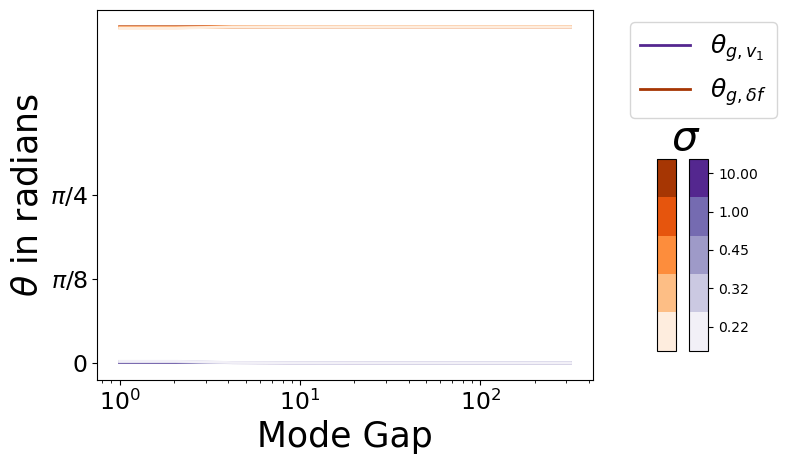

In [132]:
colors = [pal.Purples_5.mpl_colors[i] for i in range(len(sigmas))]
colors2 = [pal.Oranges_5.mpl_colors[i] for i in range(len(sigmas))]
for j in range(len(sigmas)):
    labels =[r'$\theta_{g,v_1}$','_nolegend_','_nolegend_','_nolegend_','_nolegend_']
    plt.plot(mode_gaps,alphas_g[:,j],color = colors[len(sigmas)-j-1],linewidth = 2,label = labels[j])
    labels =[r'$\theta_{g,\delta f}$','_nolegend_','_nolegend_','_nolegend_','_nolegend_']

    plt.plot(mode_gaps,theta - alphas_g[:,j],color = colors2[len(sigmas)-j-1],linewidth = 2,label = labels[j])
plt.xscale('log')
plt.legend( bbox_to_anchor=(1.05, 1),fontsize=18)
plt.ylabel(r'$\theta$ in radians', fontsize=25)
plt.yticks([0,np.pi/8,np.pi/4],["$0$",r"$\pi/8$",r"$\pi/4$"])
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
# Increase the tick size for both x and y axes
for tick in xticks + yticks:
    tick.set_fontsize(17)  # Adjust the font size as desired
plt.xlabel('Mode Gap', fontsize=25)

cmap = ListedColormap(colors)
cbar_ax = plt.gcf().add_axes([1.05, 0.17, 0.03, 0.4])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
cbar.set_ticks([i*.2 + .125 for i in range(len(sigmas))])
cbar.set_ticklabels([f'{param:.2f}' for param in (1/np.sqrt(sigmas))[::-1]])
cbar.ax.set_title('$\sigma$   ', fontsize=30)

cmap = ListedColormap(colors2)
cbar_ax = plt.gcf().add_axes([1, 0.17, 0.03, 0.4])

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
cbar.set_ticks([])
plt.savefig("revisedalphag.svg", format="svg")

In [85]:
n = 2
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -20
n_perturbs = 2000

v_1 = np.zeros(n)
v_1[0] = 1
sigma = 200
thetas = np.linspace(0.001,np.pi/2-0.001,500)

initial_guess = [np.pi/2, np.pi/2]  

s_bounds = (0, np.pi/2)  
g_bounds = (0, np.pi/2)  
# Create a bounds tuple for optimization
bounds = [s_bounds, g_bounds]

mode_gaps = np.logspace(0,2.5,9)

alphas_s = np.zeros((len(mode_gaps),len(thetas)))
alphas_g = np.zeros((len(mode_gaps),len(thetas)))

for j in tqdm(range(len(thetas))):
    theta = thetas[j]
    initial_guess = [theta/2, theta/2]  
    s_bounds = (0, theta)  
    g_bounds = (0, theta)  
    # Create a bounds tuple for optimization
    bounds = [s_bounds, g_bounds]
    df = np.array([np.cos(theta),np.sin(theta)])
    dfs = np.array([df])
    df_orth = np.array(df)
    df_orth[0] = 0
    df_orth = df_orth/np.linalg.norm(df_orth)
    for i in range(len(mode_gaps)):
        Jx[0,0]= -20/mode_gaps[i]
        # Call the minimize function to optimize the function while keeping other variables fixed
        result = minimize(func_to_optimize, initial_guess, args=(df_orth, dfs, Jx), bounds=bounds)
    
        # Extract the optimized values of x and y
        optimal_s, optimal_g = result.x
        alphas_s[i,j] = optimal_s
        alphas_g[i,j] = optimal_g

100%|███████████████████████████████████| 500/500 [00:15<00:00, 31.97it/s]


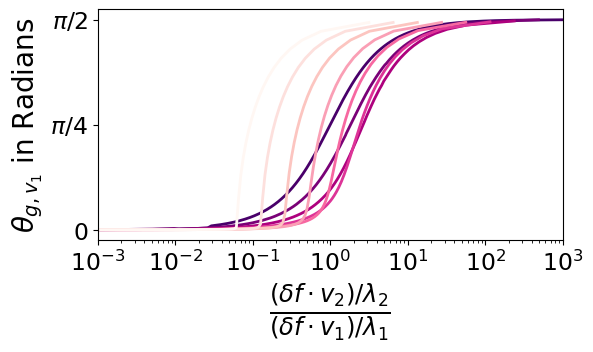

In [130]:
colors = pal.RdPu_9.mpl_colors[::-1]
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 3))
for i in range(len(mode_gaps)):
    plt.plot(np.sin(thetas)/np.cos(thetas)/mode_gaps[i],alphas_g[i,:],color = colors[i],linewidth = 2)
plt.xscale('log')
plt.xlabel(r'$\frac{(\delta f \cdot v_2) / \lambda_2}{(\delta f \cdot v_1) / \lambda_1}$', fontsize=25)
plt.ylabel(r'$\theta_{g,v_1}$ in Radians', fontsize=20)
plt.yticks([0,np.pi/4,np.pi/2],["$0$",r"$\pi/4$",r"$\pi/2$"])
plt.xlim([10**-3,10**3])
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for tick in xticks + yticks:
    tick.set_fontsize(17)  # Adjust the font size as desired
#plt.yscale('log')
norm = plt.Normalize(min(mode_gaps), max(mode_gaps))

#cbar_ax = plt.gcf().add_axes([0.78, 0.22, 0.03, 0.4])



cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
cbar.set_ticks([1/len(mode_gaps)*(i) + 1/12 for i in range(len(mode_gaps))])
cbar.set_ticklabels([f'{param:.0f}' for param in np.round(mode_gaps).astype(int)])
cbar.ax.set_title('Mode\nGap', fontsize=15)
plt.savefig("revisedcollapse.svg", format="svg")
plt.show()

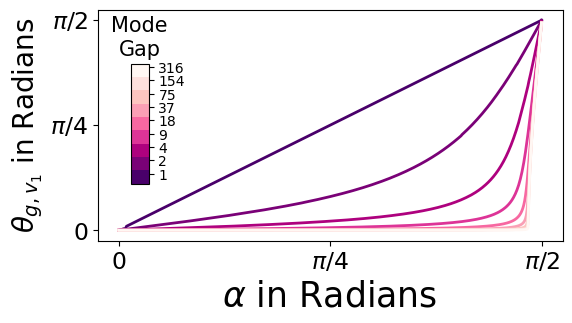

In [131]:
colors = pal.RdPu_9.mpl_colors[::-1]
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 3))
for i in range(len(mode_gaps)):
    plt.plot(thetas,alphas_g[i,:],color = colors[i],linewidth = 2)
#plt.xscale('log')
plt.xlabel(r'$\alpha$ in Radians', fontsize=25)
plt.ylabel(r'$\theta_{g,v_1}$ in Radians', fontsize=20)
plt.yticks([0,np.pi/4,np.pi/2],["$0$",r"$\pi/4$",r"$\pi/2$"])
plt.xticks([0,np.pi/4,np.pi/2],["$0$",r"$\pi/4$",r"$\pi/2$"])

#plt.xlim([10**-3,10**3])
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for tick in xticks + yticks:
    tick.set_fontsize(17)  # Adjust the font size as desired
#plt.yscale('log')
norm = plt.Normalize(min(mode_gaps), max(mode_gaps))

cbar_ax = plt.gcf().add_axes([0.18, 0.3, 0.03, 0.4])



cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
cbar.set_ticks([1/len(mode_gaps)*(i) + 1/12 for i in range(len(mode_gaps))])
cbar.set_ticklabels([f'{param:.0f}' for param in np.round(mode_gaps).astype(int)])
cbar.ax.set_title('Mode\nGap', fontsize=15)
plt.savefig("revisedalpha.svg", format="svg")
plt.show()

In [133]:
ns = [2,4,6,8,10]
mode_gaps = np.logspace(0,2.5,60)
sigma = 1
alphas_s = np.zeros((len(mode_gaps),len(ns)))
alphas_g = np.zeros((len(mode_gaps),len(ns)))
doctor_effectiveness = np.zeros((len(mode_gaps),len(ns)))
for j in tqdm(range(len(ns))):
    n = ns[j]
    Jx = np.zeros((n,n))
    for i in range(n):
        Jx[i,i] = -2
    Jx[0,0]= -2/mode_gap
    df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
    n_perturbs = 2000
    sigma = 0.1

    v_1 = np.zeros(n)
    v_1[0] = 1
    df_orth = np.array(df)
    df_orth[0] = 0
    df_orth = df_orth/np.linalg.norm(df_orth)
    theta = np.arccos(np.dot(df,v_1))
    initial_guess = [theta/2, theta/2]  

    s_bounds = (0, theta)  
    g_bounds = (0, theta)  
    # Create a bounds tuple for optimization
    bounds = [s_bounds, g_bounds]

    dfs = generate_distributed_vectors(df,n_perturbs,sigma)
    for i in range(len(mode_gaps)):
        Jx[0,0]= -2/mode_gaps[i]
        Jxinv = np.linalg.inv(Jx)
        # Call the minimize function to optimize the function while keeping other variables fixed
        result = minimize(func_to_optimize, initial_guess, args=(df_orth, dfs, Jx), bounds=bounds)
    
        # Extract the optimized values of x and y
        optimal_s, optimal_g = result.x
        alphas_s[i,j] = optimal_s
        alphas_g[i,j] = optimal_g
        doctor_effectiveness[i,j] = func_to_optimize((optimal_s, optimal_g), df_orth, dfs, Jx)/np.mean([dx_norm_efficient(dfp,Jxinv,0) for dfp in dfs])

100%|███████████████████████████████████████| 5/5 [01:35<00:00, 19.07s/it]


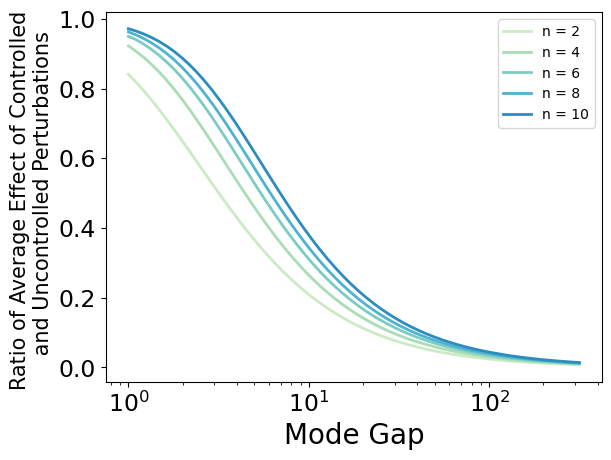

In [141]:
colors = pal.GnBu_7.mpl_colors[1:]
for j in range(len(ns)):
    plt.plot(mode_gaps,doctor_effectiveness[:,j],color = colors[j], label = "n = " + str(ns[j]),linewidth=2)
plt.xlabel('Mode Gap', fontsize=20)
plt.ylabel('Ratio of Average Effect of Controlled \n and Uncontrolled Perturbations', fontsize=15)
plt.xscale('log')
plt.legend()
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for tick in xticks + yticks:
    tick.set_fontsize(17)  # Adjust the font size as desired
plt.savefig("manyd.svg", format="svg")